In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt
from ADF_2d import ADF

## 设置窗口宽度

In [2]:
dx = 0.5
n_x = int(8/dx)
n_y = int(3/dx)
p_x = int(800/n_x+1)
p_y = int(300/n_y+1)
print(n_x,n_y)
print(p_x,p_y)
self_split = 2

16 6
51 51


## 近似距离函数生成及数据集分割

#### 边界

(300, 800)


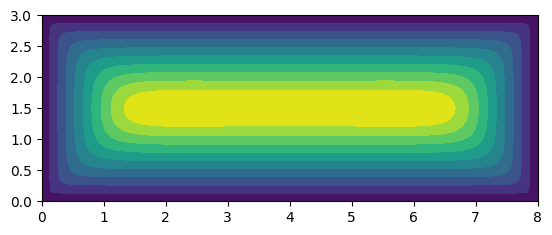

In [37]:
points_list = [[0,0],[8,0],[8,3],[0,3]]
adf = ADF(points_list)
H_c = adf.calculate()
X,Y = np.meshgrid(np.linspace(0,8,800),np.linspace(0,3,300))
H = H_c(X,Y)
print(H.shape)

H_min = np.min(H)
H_max = np.max(H)

H = (H - H_min) / (H_max - H_min + 1e-6)

boundary_d = H.copy()
# boundary_d[:100,400:500] = int(0)
fig = plt.figure()
ax = fig.add_subplot(111)
count = ax.contourf(X,Y,boundary_d,10)
# bar = fig.colorbar(count)
ax.set_aspect('equal')
plt.show()

#### 障碍物

(300, 800)


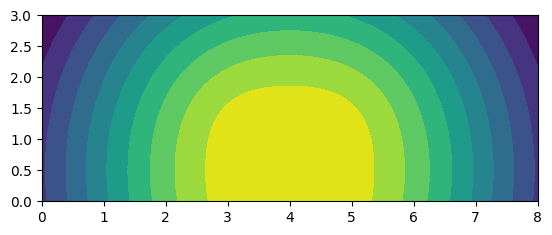

In [38]:
obstacle_points_list = [[3.5,0],[3.5,1],[4.5,1],[4.5,0]]
adf = ADF(obstacle_points_list)
H_o = adf.calculate()
X,Y = np.meshgrid(np.linspace(0,8,800),np.linspace(0,3,300))
H = H_o(X,Y)
print(H.shape)
H = np.exp(-H/16)

H_min = np.min(H)
H_max = np.max(H)

H = (H - H_min) / (H_max - H_min + 1e-6)

obstacle_d = H.copy()
# boundary_d[:100,400:500] = int(0)
fig = plt.figure()
ax = fig.add_subplot(111)
count = ax.contourf(X,Y,obstacle_d,10)
# bar = fig.colorbar(count)
ax.set_aspect('equal')
plt.show()

#### 出入口

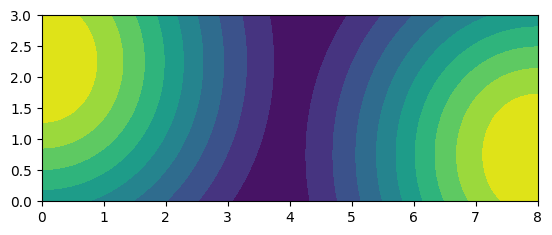

In [39]:
face_1_point_list = [[0,2],[0,2.5]]
face_2_point_list = [[8,0.5],[8,1]]
adf_1 = ADF(face_1_point_list)
adf_2 = ADF(face_2_point_list)
face_1 = adf_1.calculate()
face_2 = adf_2.calculate()
X,Y = np.meshgrid(np.linspace(0,8,800),np.linspace(0,3,300))
H_1 = face_1(X,Y)
h_1 = np.exp(-H_1/16)
H_2 = face_2(X,Y)
h_2 = np.exp(-H_2/16)
h = np.maximum(h_1,h_2)

H_min = np.min(h)
H_max = np.max(h)

H = (h - H_min) / (H_max - H_min + 1e-6)

inout_d = H.copy()
fig = plt.figure()
ax = fig.add_subplot(111)
count = ax.contourf(X,Y,inout_d,10)
# bar = fig.colorbar(count)
ax.set_aspect('equal')
plt.show()

#### 切割成96份

In [40]:
print(boundary_d.shape)
d_bound = np.empty((n_x,n_y,p_x,p_y))
for i in range(n_x):
	for j in range(n_y):
		if i == (n_x-1) and j != (n_y-1):
			d_bound[i,j,:,:] = boundary_d[j*(p_y-1):(j+1)*(p_y-1)+1,-(p_x):]
		elif j == (n_y-1) and i != (n_x-1):
			d_bound[i,j,:,:] = boundary_d[-(p_y):,i*(p_x-1):(i+1)*(p_x-1)+1]
		elif i == (n_x-1) and j == (n_y-1):
			d_bound[i,j,:,:] = boundary_d[-(p_x):,-(p_y):]
		else:
			d_bound[i,j,:,:] = boundary_d[j*(p_y-1):(j+1)*(p_y-1)+1,i*(p_x-1):(i+1)*(p_x-1)+1]
d_bound = d_bound.reshape((-1,p_x,p_y))
print(d_bound.shape)

print(obstacle_d.shape)
d_obstacle = np.empty((n_x,n_y,p_x,p_y))
for i in range(n_x):
	for j in range(n_y):
		if i == (n_x-1) and j != (n_y-1):
			d_obstacle[i,j,:,:] = obstacle_d[j*(p_y-1):(j+1)*(p_y-1)+1,-(p_x):]
		elif j == (n_y-1) and i != (n_x-1):
			d_obstacle[i,j,:,:] = obstacle_d[-(p_y):,i*(p_x-1):(i+1)*(p_x-1)+1]
		elif i == (n_x-1) and j == (n_y-1):
			d_obstacle[i,j,:,:] = obstacle_d[-(p_x):,-(p_y):]
		else:
			d_obstacle[i,j,:,:] = obstacle_d[j*(p_y-1):(j+1)*(p_y-1)+1,i*(p_x-1):(i+1)*(p_x-1)+1]
d_obstacle = d_obstacle.reshape((-1,p_x,p_y))
print(d_obstacle.shape)

print(inout_d.shape)
d_inout = np.empty((n_x,n_y,p_x,p_y))
for i in range(n_x):
	for j in range(n_y):
		if i == (n_x-1) and j != (n_y-1):
			d_inout[i,j,:,:] = inout_d[j*(p_y-1):(j+1)*(p_y-1)+1,-(p_x):]
		elif j == (n_y-1) and i != (n_x-1):
			d_inout[i,j,:,:] = inout_d[-(p_y):,i*(p_x-1):(i+1)*(p_x-1)+1]
		elif i == (n_x-1) and j == (n_y-1):
			d_inout[i,j,:,:] = inout_d[-(p_x):,-(p_y):]
		else:
			d_inout[i,j,:,:] = inout_d[j*(p_y-1):(j+1)*(p_y-1)+1,i*(p_x-1):(i+1)*(p_x-1)+1]
d_inout = d_inout.reshape((-1,p_x,p_y))
print(d_inout.shape)

(300, 800)
(24, 101, 101)
(300, 800)
(24, 101, 101)
(300, 800)
(24, 101, 101)


#### 保存距离函数

In [41]:
data = np.stack((d_inout,d_obstacle,d_bound),axis=-1)
print(data.shape)
np.save(r'I:\ML\工况合集\data\data_test\test_distance_data_1m.npy',data)

(24, 101, 101, 3)


#### 测试训练集

(96, 51, 51)


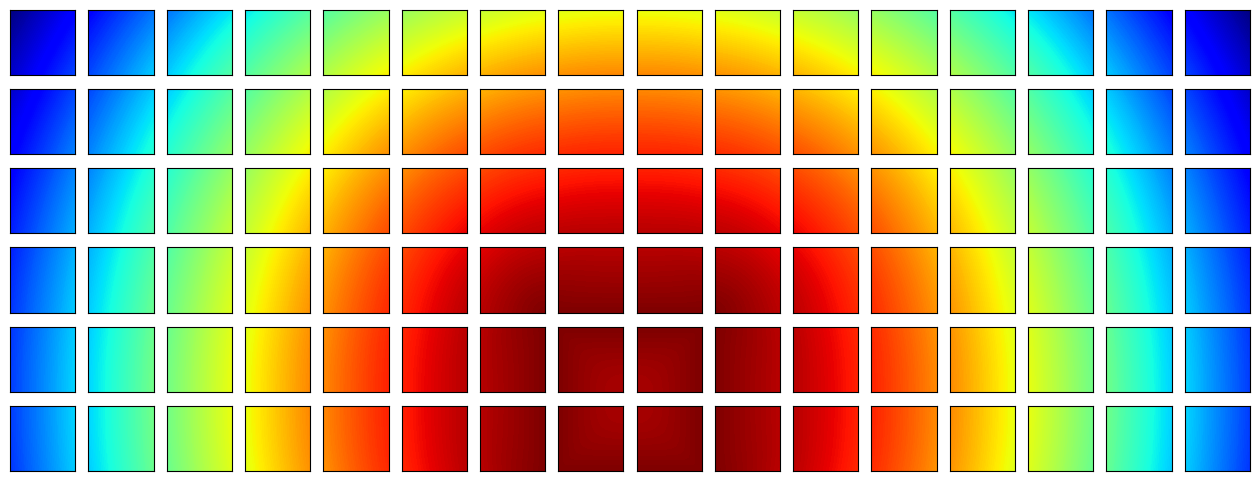

In [3]:
data = np.load(r'I:\ML\工况合集\data\data_test\test_distance_data.npy')
data_0 = data[...,0]
data_1 = data[...,1]
data_2 = data[...,2]
see_data = data_1

coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(n_x,n_y))
print(see_data.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[n_y-1-i,j].contourf(coordinate[0], coordinate[1], see_data[i+j*n_y,:,:], 100, cmap='jet', vmin=0, vmax=1)
		axs[n_y-1-i,j].set_aspect('equal')
		axs[n_y-1-i,j].set_xticks([])
		axs[n_y-1-i,j].set_yticks([])

plt.show()

## 数据集生成

#### [231201,3] -> [96,51,51,1]

In [44]:
truth = np.loadtxt(r'I:\ML\工况合集\data\labels_data\test')
print(truth.shape)

(241101, 3)


In [45]:
def enhance_data(datafile, is_pred=False):
		# split
		x = np.round(datafile[:,0],2)
		y = np.round(datafile[:,1],2)
		a = datafile[:,2]

		# set the index
		eps = 1e-6
		indices = [[np.where((i*dx-eps<=datafile[:,0]) & (datafile[:,0]<=(i+1)*dx+eps) & (j*dx-eps<=datafile[:,1]) & (datafile[:,1]<=(j+1)*dx+eps)) for j in range(n_y)] for i in range(n_x)]		# 8*3*10201
		# 将数据分为8*3*10201的数组
		xx = np.zeros((n_x,n_y,p_x*p_y))
		yy = np.zeros((n_x,n_y,p_x*p_y))
		aa = np.zeros((n_x,n_y,p_x*p_y))

		for i in range(n_x):
			for j in range(n_y):
				# if 6<=i<=7 and 0<=j<=1:
				# 	continue
				xx[i,j,:] = x[indices[i][j][0]]
				yy[i,j,:] = y[indices[i][j][0]]
				aa[i,j,:] = a[indices[i][j][0]]

		xx = xx.reshape(n_x,n_y,p_x,p_y)
		yy = yy.reshape(n_x,n_y,p_x,p_y)
		aa = aa.reshape(n_x,n_y,p_x,p_y)

		# 现在有8*3*51*51的uvp数据，需要对其数据强化
		x_original = np.empty((0, p_x, p_y))
		y_original = np.empty((0, p_x, p_y))
		a_original = np.empty((0, p_x, p_y))

		if is_pred:
			'''
			如果是用来预测，将16*6*51*51的数据按顺序整理成96*51*51的数据
			'''
			for i in range(n_x):
				for j in range(n_y):
					x_original = np.vstack((x_original,xx[i,j,:,:].reshape(1,p_x,p_y)))
					y_original = np.vstack((y_original,yy[i,j,:,:].reshape(1,p_x,p_y)))
					a_original = np.vstack((a_original,aa[i,j,:,:].reshape(1,p_x,p_y)))


		else:
			'''
			如果是用来训练，将16*6*51*51的数据强化，一个图分split进行组合。
			'''
			split = self_split
			for i in range(n_x-1):
				for j in range(n_y-1):
					for m in range(split):
						for n in range(split):
							x_temp0 = xx[i,j,m*p_x//split:,n*p_y//split:]
							x_temp1 = xx[i+1,j,m*p_x//split:,:n*p_y//split]
							x_temp2 = xx[i,j+1,:m*p_x//split,n*p_y//split:]
							x_temp3 = xx[i+1,j+1,:m*p_x//split,:n*p_y//split]
							x_temp01 = np.concatenate((x_temp0,x_temp1),axis = 1)
							x_temp23 = np.concatenate((x_temp2,x_temp3),axis = 1)
							x_temp = np.concatenate((x_temp01,x_temp23),axis = 0).reshape(1,p_x,p_y)
							x_original = np.vstack((x_original,x_temp))

							y_temp0 = yy[i,j,m*p_x//split:,n*p_y//split:]
							y_temp1 = yy[i+1,j,m*p_x//split:,:n*p_y//split]
							y_temp2 = yy[i,j+1,:m*p_x//split,n*p_y//split:]
							y_temp3 = yy[i+1,j+1,:m*p_x//split,:n*p_y//split]
							y_temp01 = np.concatenate((y_temp0,y_temp1),axis = 1)
							y_temp23 = np.concatenate((y_temp2,y_temp3),axis = 1)
							y_temp = np.concatenate((y_temp01,y_temp23),axis = 0).reshape(1,p_x,p_y)
							y_original = np.vstack((y_original,y_temp))

							a_temp0 = aa[i,j,m*p_x//split:,n*p_y//split:]
							a_temp1 = aa[i+1,j,m*p_x//split:,:n*p_y//split]
							a_temp2 = aa[i,j+1,:m*p_x//split,n*p_y//split:]
							a_temp3 = aa[i+1,j+1,:m*p_x//split,:n*p_y//split]
							a_temp01 = np.concatenate((a_temp0,a_temp1),axis = 1)
							a_temp23 = np.concatenate((a_temp2,a_temp3),axis = 1)
							a_temp = np.concatenate((a_temp01,a_temp23),axis = 0).reshape(1,p_x,p_y)
							a_original = np.vstack((a_original,a_temp))

		return a_original

In [46]:
truth_data = enhance_data(truth, True)
truth_data = truth_data.reshape(n_x*n_y,p_x,p_y,1)
np.save(r'I:\ML\工况合集\data\data_test\test_label_1m.npy',truth_data)

检查数据集是否正确

In [4]:
truth_data = np.load(r'I:\ML\工况合集\data\data_test\test_label.npy')
print(truth_data.shape)

(96, 51, 51, 1)


(96, 51, 51, 1)


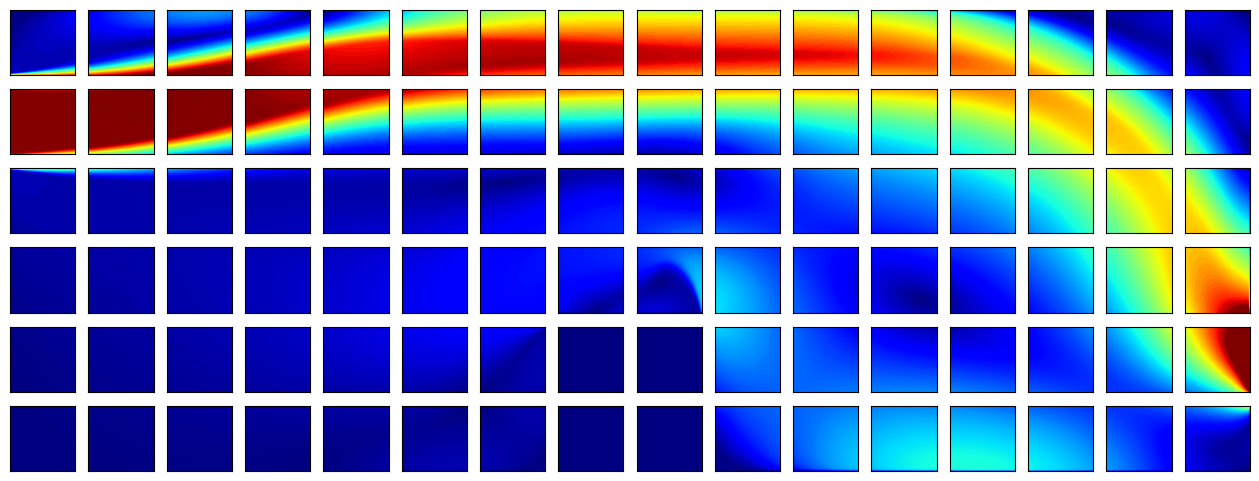

In [5]:
coordinate = np.meshgrid(np.linspace(0,dx,p_x),np.linspace(0,dx,p_y))
fig,axs = plt.subplots(n_y,n_x,figsize=(n_x,n_y))
print(truth_data.shape)
for i in range(n_y):
	for j in range(n_x):
		axs[(n_y-1)-i,j].contourf(coordinate[0], coordinate[1], truth_data[i+j*(n_y),:,:,0], 100, cmap='jet', vmin=0, vmax=1)
		axs[(n_y-1)-i,j].set_aspect('equal')
		axs[(n_y-1)-i,j].set_xticks([])
		axs[(n_y-1)-i,j].set_yticks([])


plt.show()

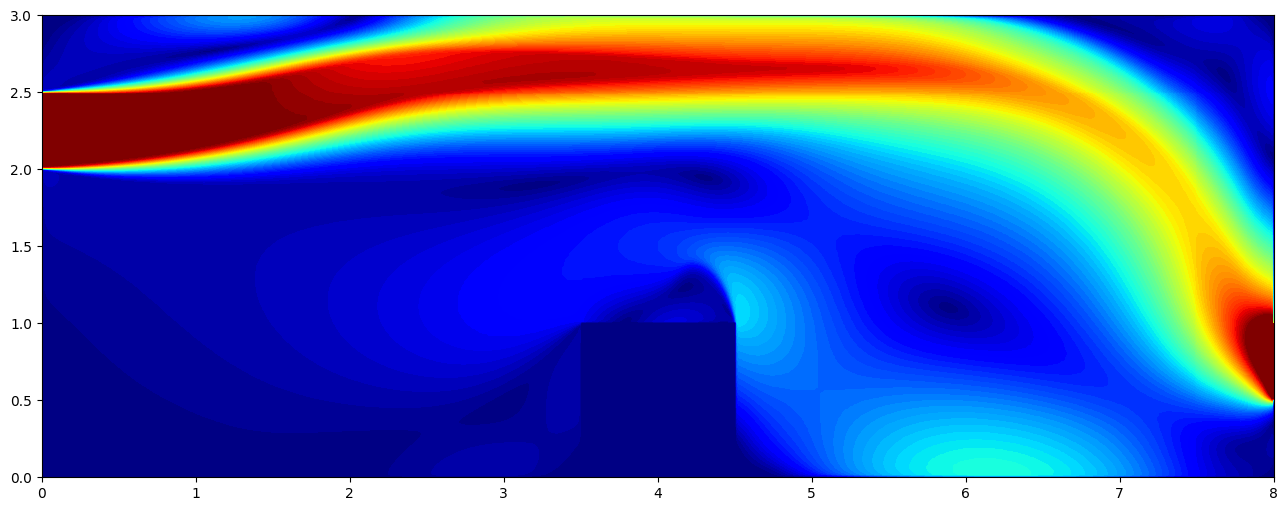

In [14]:
all_zone = np.zeros((300,800))
for i in range(n_y):
	for j in range(n_x):
		if i == n_y-1 and j != n_x-1:
			all_zone[-(p_x):,j*(p_y-1):(j+1)*(p_y-1)+1] = truth_data[i+j*(n_y),:,:,0]
		elif i != n_y-1 and j == n_x-1:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,-(p_y):] = truth_data[i+j*(n_y),:,:,0]
		elif i == n_y-1 and j == n_x-1:
			all_zone[-(p_x):,-(p_y):] = truth_data[i+j*(n_y),:,:,0]
		else:
			all_zone[i*(p_x-1):(i+1)*(p_x-1)+1,j*(p_y-1):(j+1)*(p_y-1)+1] = truth_data[i+j*(n_y),:,:,0]

fig,axs = plt.subplots(1,figsize=(n_x,n_y))
axs.contourf(np.linspace(0,8,800),np.linspace(0,3,300),all_zone,100,cmap='jet',vmin=0,vmax=1)
axs.set_aspect('equal')

## 距离函数和数据进一步分割

#### 距离函数分割

In [49]:
train_data = np.load(r'I:\ML\工况合集\data\data_test\test_distance_data_1m.npy')
print(train_data.shape)

(24, 101, 101, 3)


In [50]:
train_data = train_data.reshape(n_x,n_y,p_x,p_y,3)
train_data_input = train_data[...,0]
train_data_obstacle = train_data[...,1]
train_data_boundary = train_data[...,2]
print(train_data_input.shape)
print(train_data_obstacle.shape)
print(train_data_boundary.shape)

(8, 3, 101, 101)
(8, 3, 101, 101)
(8, 3, 101, 101)


In [51]:
split = self_split

x_original = np.empty((0, p_x, p_y))
z_original = np.empty((0, p_x, p_y))
y_original = np.empty((0, p_x, p_y))
u_original = np.empty((0, p_x, p_y))

for i in range(n_x-1):
	for j in range(n_y-1):
		for m in range(split):
			for n in range(split):
				x_temp0 = train_data_input[i,j,m*p_x//split:,n*p_y//split:]
				x_temp1 = train_data_input[i+1,j,m*p_x//split:,:n*p_y//split]
				x_temp2 = train_data_input[i,j+1,:m*p_x//split,n*p_y//split:]
				x_temp3 = train_data_input[i+1,j+1,:m*p_x//split,:n*p_y//split]
				x_temp01 = np.concatenate((x_temp0,x_temp1),axis = 1)
				x_temp23 = np.concatenate((x_temp2,x_temp3),axis = 1)
				x_temp = np.concatenate((x_temp01,x_temp23),axis = 0).reshape(1,p_x,p_y)
				x_original = np.vstack((x_original,x_temp))

				z_temp0 = train_data_obstacle[i,j,m*p_x//split:,n*p_y//split:]
				z_temp1 = train_data_obstacle[i+1,j,m*p_x//split:,:n*p_y//split]
				z_temp2 = train_data_obstacle[i,j+1,:m*p_x//split,n*p_y//split:]
				z_temp3 = train_data_obstacle[i+1,j+1,:m*p_x//split,:n*p_y//split]
				z_temp01 = np.concatenate((z_temp0,z_temp1),axis = 1)
				z_temp23 = np.concatenate((z_temp2,z_temp3),axis = 1)
				z_temp = np.concatenate((z_temp01,z_temp23),axis = 0).reshape(1,p_x,p_y)
				z_original = np.vstack((z_original,z_temp))

				y_temp0 = train_data_boundary[i,j,m*p_x//split:,n*p_y//split:]
				y_temp1 = train_data_boundary[i+1,j,m*p_x//split:,:n*p_y//split]
				y_temp2 = train_data_boundary[i,j+1,:m*p_x//split,n*p_y//split:]
				y_temp3 = train_data_boundary[i+1,j+1,:m*p_x//split,:n*p_y//split]
				y_temp01 = np.concatenate((y_temp0,y_temp1),axis = 1)
				y_temp23 = np.concatenate((y_temp2,y_temp3),axis = 1)
				y_temp = np.concatenate((y_temp01,y_temp23),axis = 0).reshape(1,p_x,p_y)
				y_original = np.vstack((y_original,y_temp))

				# u_temp0 = truth_data[i,j,m*51//split:,n*51//split:]
				# u_temp1 = truth_data[i+1,j,m*51//split:,:n*51//split]
				# u_temp2 = truth_data[i,j+1,:m*51//split,n*51//split:]
				# u_temp3 = truth_data[i+1,j+1,:m*51//split,:n*51//split]
				# u_temp01 = np.concatenate((u_temp0,u_temp1),axis = 1)
				# u_temp23 = np.concatenate((u_temp2,u_temp3),axis = 1)
				# u_temp = np.concatenate((u_temp01,u_temp23),axis = 0).reshape(1,51,51)
				# u_original = np.vstack((u_original,u_temp))

In [52]:
train_data = np.stack((x_original,z_original,y_original),axis=-1)
print(train_data.shape)

(56, 101, 101, 3)


In [53]:
np.save(r'I:\ML\工况合集\data\data_test\distance_test_split_2_1m',train_data)

#### 数据分割

In [54]:
truth_data = np.load(r'I:\ML\工况合集\data\data_test\test_label_1m.npy')
print(truth_data.shape)

(24, 101, 101, 1)


In [55]:
truth_data = truth_data.reshape(n_x,n_y,p_x,p_y,1)
truth_data = truth_data[...,0]
print(truth_data.shape)

(8, 3, 101, 101)


In [56]:
split = self_split

u_original = np.empty((0, p_x, p_y))

for i in range(n_x-1):
	for j in range(n_y-1):
		for m in range(split):
			for n in range(split):

				u_temp0 = truth_data[i,j,m*p_x//split:,n*p_y//split:]
				u_temp1 = truth_data[i+1,j,m*p_x//split:,:n*p_y//split]
				u_temp2 = truth_data[i,j+1,:m*p_x//split,n*p_y//split:]
				u_temp3 = truth_data[i+1,j+1,:m*p_x//split,:n*p_y//split]
				u_temp01 = np.concatenate((u_temp0,u_temp1),axis = 1)
				u_temp23 = np.concatenate((u_temp2,u_temp3),axis = 1)
				u_temp = np.concatenate((u_temp01,u_temp23),axis = 0).reshape(1,p_x,p_y)
				u_original = np.vstack((u_original,u_temp))

In [57]:
truth_data = u_original.reshape(-1,p_x,p_y,1)
print(truth_data.shape)

(56, 101, 101, 1)


In [58]:
np.save(r'I:\ML\工况合集\data\data_test\label_test_split_2_1m.npy',truth_data)